# Кейс 11. Анализ А/Б-теста для "Дункан МакКлауд" 

Был запущен А/Б-тест на два вида лендинга:
А - короткий, на один экран, с ярким call-to-action,
Б - длинный, с подробным разъяснением всех плюсов платформы для облачного хранения данных «Дункан МакКлауд».

## Задача: 
Определить с какого лендинга приходит больше людей? Какое качество этих пользователей (в денежном эквиваленте)?

### Подготовка данных:
#### Импортируем нужные библиотеки и функции

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.weightstats import ztest
from datetime import datetime

#### Читаем таблицу ab_test_cookies

In [2]:
cookies = pd.read_csv('ab_test_cookies.csv')
cookies

,cookie_id,grp
0,65hj0vyf6kfrckx,A
1,dnjw8oy95td2jqf,B
2,beiyb0xfie92m43,B
3,xyd746tr80pnnbi,B
4,dpq6rqi93zgekgv,A
...,...,...
253167,e2e7xo4mh9gbqpb,A
253168,cmwfr9djxdj6vgr,B
253169,0ou6tl9qdzq9w4x,B
253170,c375picbbkkzfy9,B


#### Читаем таблицу registrations_in_test_period

In [3]:
registrations = pd.read_csv('registrations_in_test_period.csv')
registrations

,cookie_id,user_id
0,NaN,382603
1,NaN,295154
2,NaN,999732
3,NaN,16486
4,NaN,678352
...,...,...
172345,cnktcu0sdbzr7bb,492436
172346,NaN,213291
172347,NaN,684800
172348,kphh4v8s6lk187h,262963


#### Читаем таблицу purchases_in_test_period

In [4]:
purchases = pd.read_csv('purchases_in_test_period.csv')
purchases

,purchase_id,user_id,amount
0,1,275851,350
1,2,923077,1500
2,3,959409,50
3,4,692022,350
4,5,737918,50
...,...,...,...
35142,35143,473919,1500
35143,35144,917205,350
35144,35145,635988,50
35145,35146,525611,1500


Так как у пользователя может быть несколько покупок, нам нужно провести агрегацию по пользователю:

In [5]:
gr_purchases = purchases.groupby('user_id', as_index = False).agg({'amount':'sum'})
gr_purchases

,user_id,amount
0,0,350
1,27,700
2,33,350
3,61,50
4,76,1500
...,...,...
33735,999817,50
33736,999837,350
33737,999877,350
33738,999915,350


#### Cоединим наши таблицы

Учитываем, что в таблице **cookies** содержится информация о пользователях, посетивших лендинг, а в дальнейшем зарегистрировавшихся (есть данные в таблице **registrations**) и незарегистрировавшихся на платформе, а в таблице **registrations** есть также данные по пользователям, пришедшим вне лендинга, объединяем данные по left join:

In [6]:
cook_reg = cookies.merge(registrations, on = 'cookie_id', how = 'left')
cook_reg.head()

,cookie_id,grp,user_id
0,65hj0vyf6kfrckx,A,716849.0
1,dnjw8oy95td2jqf,B,NaN
2,beiyb0xfie92m43,B,NaN
3,xyd746tr80pnnbi,B,NaN
4,dpq6rqi93zgekgv,A,NaN


Посмотрим, сколько пользователей пришло из каждого лендинга:

In [7]:
cook_reg.groupby('grp').agg({'user_id':'count'})

,user_id
grp,
A,31439
B,41046


С **лендинга В** пришло **больше пользователей**.

**Соединим таблицы** с данными об участниках теста и с данными о покупках:

In [8]:
new_table = cook_reg.merge(gr_purchases, on = 'user_id', how = 'left')
new_table

,cookie_id,grp,user_id,amount
0,65hj0vyf6kfrckx,A,716849.0,NaN
1,dnjw8oy95td2jqf,B,NaN,NaN
2,beiyb0xfie92m43,B,NaN,NaN
3,xyd746tr80pnnbi,B,NaN,NaN
4,dpq6rqi93zgekgv,A,NaN,NaN
...,...,...,...,...
253167,e2e7xo4mh9gbqpb,A,334362.0,NaN
253168,cmwfr9djxdj6vgr,B,NaN,NaN
253169,0ou6tl9qdzq9w4x,B,NaN,NaN
253170,c375picbbkkzfy9,B,NaN,NaN


### Анализ данных

Посмотрим, **в каких пропорциях разбиты пользователи на группы** и **сколько пользователей** в каждой группе **что-то купило** (buyers), а также определим общее количество пользователей (visitors), которые посмотрели лендинг (из них users - которые зарегистрировались после просмотра):

In [9]:
new_table_summary = new_table.groupby('grp').agg({'user_id':'count','amount':'count', 'cookie_id':'count'}).rename(columns={'user_id':'users','amount':'buyers','cookie_id':'visitors'}) #Агрегация данных
new_table_summary

,users,buyers,visitors
grp,,,
A,31439,5815,101329
B,41046,8797,151843


Посчитаем, какая **доля пользователей** находится в группе А и в группе В:

In [10]:
new_table_summary.loc[new_table_summary.index == 'A', 'users'].sum()/new_table_summary.users.sum()

0.43373111678278264

In [11]:
new_table_summary.loc[new_table_summary.index == 'B', 'users'].sum()/new_table_summary.users.sum()

0.5662688832172174

В нашем случае в группе А - 43,4 % пользователей, а в группе В - 56,6% пользователей.

#### Считаем  конверсию пользователя из просмотра лендинга в покупателя и конверсию в покупку

In [12]:
new_table_summary['conversion_landing'] = ((new_table_summary.buyers/new_table_summary.visitors)*100) #Конверсия пользователя из просмотра лендинга в покупателя
new_table_summary['conversion_buying'] = ((new_table_summary.buyers/new_table_summary.users)*100) # Конверсия в покупку
new_table_summary

,users,buyers,visitors,conversion_landing,conversion_buying
grp,,,,,
A,31439,5815,101329,5.738732,18.496135
B,41046,8797,151843,5.793484,21.432052


**Конверсия** из просмотра лендинга в покупателя в первой группе **5,74%**, а во второй — **5,79%**.
**Конверсия** в покупку в первой группе - **18,5%**, а во второй группе **21,4%**.

#### Считаем средний чек

In [13]:
new_table_summary = new_table_summary.merge(new_table.groupby('grp').agg({'amount':'mean'}).rename(columns = {'amount':'avg_bill'}), 
                 left_index = True, right_index = True) # Сделали агрегацию и прикрепили её к new_table_summary
new_table_summary

,users,buyers,visitors,conversion_landing,conversion_buying,avg_bill
grp,,,,,,
A,31439,5815,101329,5.738732,18.496135,553.052451
B,41046,8797,151843,5.793484,21.432052,623.093100


#### Считаем ARPU

Осталось подсчитать ARPU пользователей, то есть среднюю выручку на пользователя в группе, а также дополнительную выручку, которую принесла группа В.

In [14]:
new_table_summary = new_table_summary.merge(new_table.groupby('grp').agg({'amount':'sum'}).rename(columns = {'amount':'revenue'}), 
                 left_index = True, right_index = True) # Сделали агрегацию и прикрепили её к new_table_summary
new_table_summary['ARPU'] = new_table_summary.revenue/new_table_summary.users
new_table_summary['Доп. выручка'] = new_table_summary.users*(new_table_summary.ARPU - new_table_summary.loc['A', 'ARPU'])
new_table_summary

,users,buyers,visitors,conversion_landing,conversion_buying,avg_bill,revenue,ARPU,Доп. выручка
grp,,,,,,,,,
A,31439,5815,101329,5.738732,18.496135,553.052451,3216000.0,102.293330,0.000000e+00
B,41046,8797,151843,5.793484,21.432052,623.093100,5481350.0,133.541636,1.282618e+06


**ARPU** группы В выше, чем в группе А на **30,5%**, а **дополнительная выручка** в группе В составляет **1 282 618 рублей**.

***

Проверим, статистически ли значимое это изменение, то есть можно ли ему доверять.

#### Посчитаем значимость изменения конверсии

In [15]:
ztest(new_table.loc[new_table.grp == 'A', 'amount'].apply(lambda x: 1 if pd.notnull(x) else 0),# Конверсии пользователей группы А
     new_table.loc[new_table.grp == 'B', 'amount'].apply(lambda x: 1 if pd.notnull(x) else 0) # Конверсии пользователей группы B
     ) 

(-0.5787826665981052, 0.5627358282855696)

**Вывод:**

Конверсия из лендинга почти не отличается, конверсия в покупку выше в группе В.
Z-test выдаёт два параметра: z-статистику и p-value. p-value составляет 0.5627358282855696. 

#### Визуализируем и проверим с помощью статистического теста Шапиро-Вилка как распределены средний чек и покупки:

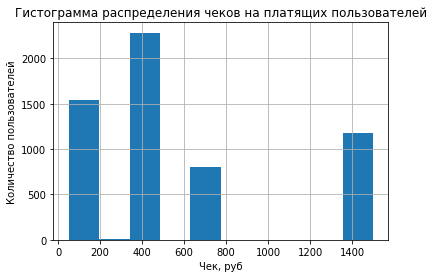

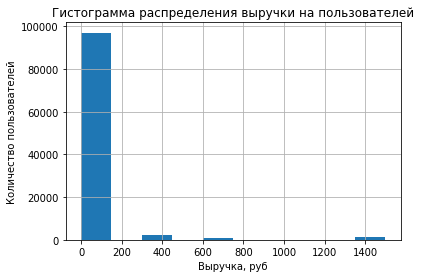

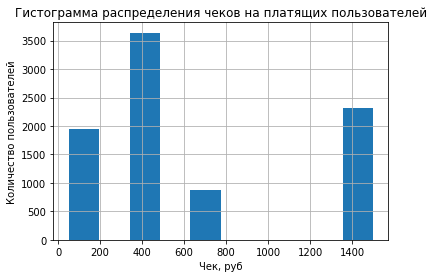

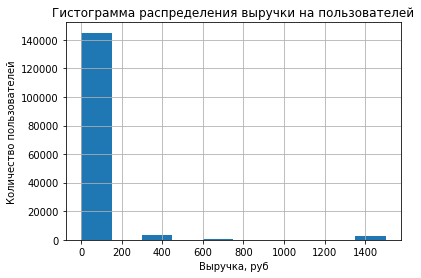

In [16]:
ax = plt.subplot()
new_table.loc[new_table.grp == 'A', 'amount'].dropna().hist()
ax.set_xlabel('Чек, руб')
ax.set_ylabel('Количество пользователей')
ax.set_title('Гистограмма распределения чеков на платящих пользователей')
plt.show()

ax = plt.subplot()
new_table.loc[new_table.grp == 'A', 'amount'].fillna(0).hist()
ax.set_xlabel('Выручка, руб')
ax.set_ylabel('Количество пользователей')
ax.set_title('Гистограмма распределения выручки на пользователей')
plt.show()

ax = plt.subplot()
new_table.loc[new_table.grp == 'B', 'amount'].dropna().hist()
ax.set_xlabel('Чек, руб')
ax.set_ylabel('Количество пользователей')
ax.set_title('Гистограмма распределения чеков на платящих пользователей')
plt.show()

ax = plt.subplot()
new_table.loc[new_table.grp == 'B', 'amount'].fillna(0).hist()
ax.set_xlabel('Выручка, руб')
ax.set_ylabel('Количество пользователей')
ax.set_title('Гистограмма распределения выручки на пользователей')
plt.show()

Очевидно, что распределение не является нормальным.

#### Применим тест Манна-Уитни

Так как распределения признаков не бинарные (0-1) и не нормальные, то нужно использовать для сравнения средних не только T-test, но и непараметрический U-тест Манна-Уитни.

##### Сравним средние чеки:

In [17]:
print(stats.mannwhitneyu(new_table.loc[new_table.grp == 'A', 'amount'].dropna(), new_table.loc[new_table.grp == 'B', 'amount'].dropna()),
stats.ttest_ind(new_table.loc[new_table.grp == 'A', 'amount'].dropna(), new_table.loc[new_table.grp == 'B', 'amount'].dropna())
      , sep = '\n')

MannwhitneyuResult(statistic=23997449.0, pvalue=1.5894355470534353e-11)
Ttest_indResult(statistic=-7.698737457881192, pvalue=1.4620086805787972e-14)


Как мы видим, средние чеки также значимо различаются (так как p-value << 0.05) по каждому из тестов.

##### Сравниваем ARPU

In [18]:
print(stats.mannwhitneyu(new_table.loc[new_table.grp == 'A', 'amount'].fillna(0), new_table.loc[new_table.grp == 'B', 'amount'].fillna(0)),
      stats.ttest_ind(new_table.loc[new_table.grp == 'A', 'amount'].fillna(0), new_table.loc[new_table.grp == 'B', 'amount'].fillna(0)),
     sep = '\n')

MannwhitneyuResult(statistic=7687257761.0, pvalue=0.2131782418227564)
Ttest_indResult(statistic=-5.6615374023743055, pvalue=1.501844531390091e-08)


**Вывод:**
P-value для ARPU для Т-теста значительно меньше 0.05, а p-value теста Манна-Уитни больше 0.05, и это все равно говорит о значимых различиях показателей.


#### Строим доверительные интервалы

Построим для каждой метрики доверительные интервалы для среднего, чтобы визуализация была более наглядной. 

In [19]:
# Важные функции для получения доверительных интервалов
def get_conf_interval(data, conf_level = 0.95):  
# Считает доверительные интервалы для средних
        buf = (stats.t.interval(conf_level, len(data),
                             loc=np.mean(data), scale=stats.sem(data)))
        return (buf[1] - buf[0])/2
    
def get_conf_interval_z(succ, tot):  
# Считает доверительные интервалы для бинарных величин
    buf = proportion_confint(succ, tot)
    return buf[1] - buf[0]

In [20]:
get_conf_interval(new_table.loc[new_table.grp == 'A', 'amount'].fillna(0)) 
# Доверительный полуинтервал для АРПУ пользователей в группе А

1.0981455326877274

In [21]:
# Составляем словарь с доверительными интервалами для каждой метрики и для каждой группы
conf_intervals = {'ARPU':{'A':get_conf_interval(new_table.loc[new_table.grp == 'A', 'amount'].fillna(0)),
                          'B':get_conf_interval(new_table.loc[new_table.grp == 'B', 'amount'].fillna(0))},
                  'conversion':{'A':get_conf_interval_z(new_table.loc[new_table.grp == 'A', 'amount'].dropna().count(),
                                                        new_table.loc[new_table.grp == 'A', 'user_id'].count()),
                               'B':get_conf_interval_z(new_table.loc[new_table.grp == 'B', 'amount'].dropna().count(),
                                                        new_table.loc[new_table.grp == 'B', 'user_id'].count())},
                  'avg_bill':{'A':get_conf_interval(new_table.loc[new_table.grp == 'A', 'amount'].dropna()),
                          'B':get_conf_interval(new_table.loc[new_table.grp == 'B', 'amount'].dropna())}
                 }

#### Составление отчета

In [22]:
# Удобная функция для подстановки подписей на barplot
def set_labels(axes):  
# Расставляет подписи столбцов на барплоты
    y0, y1 = axes.get_ybound()  
# размер графика по оси Y
    y_shift = 0.15* (y1 - y0)  
# дополнительное место под надписи

    for i, rect in enumerate(axes.patches):  
# по всем нарисованным прямоугольникам
        height = rect.get_height()
        if abs(height) <= 10000:
            label = str(round(height, 2))
            if label[-1] == '0':
                label = label[:-1]
        elif abs(height) <= 1000000:
            label = str(round(height/1000, 1))
            if label[-1] == '0':
                label = label[:-1] + 'k'
            else:
                label = label + 'k'
        else:
            label = str(round(height/1000000, 2))
            if label[-1] == '0':
                label = label[:-1] + 'm'
            else:
                label = label + 'm'
        x = rect.get_x() + rect.get_width() / 2  
# посередине прямоугольника
        y = height + y_shift * 0.8  
# над прямоугольником в середине доп. места
        if height < 0:
            y = y_shift * 0.8 
        axes.text(x, y, label, ha='center', va='center', alpha = 0.7)
        axes.set_ybound(y0, y1 + 1.5*y_shift)

In [23]:
plot_summary = new_table_summary.T 
# Транспонированная таблица для удобства использования
significant_changes = ['conversion', 'avg_bill'] 
# Метрики со статзначимыми различиями

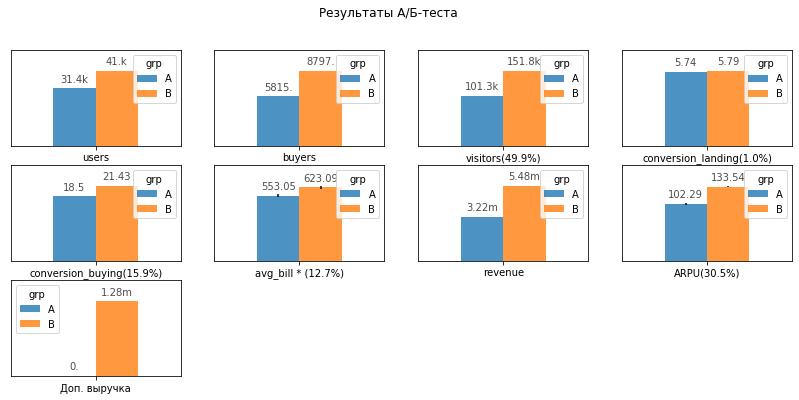

In [24]:
from matplotlib import gridspec
from math import ceil

ax = [] 
# Массив для складирования графиков
n_pict_in_line = 4 
# Количество картинок в одной линии

gs = gridspec.GridSpec(ceil(len(plot_summary) / float(n_pict_in_line)), n_pict_in_line) 
# Создаём сетку для графиков
fig = plt.figure(figsize=(n_pict_in_line*3 + 2,
                          ceil(len(plot_summary) / n_pict_in_line) * 2))

## Считаем изменение метрики в процентах
delta_percent = {}
for row in plot_summary.index:  
    if 'users' != row and 'buyers' != row and 'revenue' != row and "Доп. выручка" != row:
        delta_percent[row] = '(' + str(round(plot_summary.loc[row, :].max()/\
                                  plot_summary.loc[row, :].min()*100 - 100, 1)) + '%)'
        
fig.suptitle('Результаты А/Б-теста')

## Строим графики
for i, col in enumerate(plot_summary.index):
    ax.append(plt.subplot(gs[i // n_pict_in_line, i % n_pict_in_line])) 
# Добавляем subplot в нужную клетку
    plot_summary.loc[[col], :].plot(kind='bar', rot=0, ax=ax[i], alpha=0.8, 
# Строим график в нужной клетке
                                   yerr=conf_intervals[col] if col in conf_intervals else 0) 
    
    
# Редактируем подпись к графику, чтобы в ней хранилась информация о значимости различий 
    stars = ' * ' if col in significant_changes else '' 
    ticks = ax[-1].get_xticklabels()
    ticks[0] = col + stars + delta_percent[col] if col in delta_percent else col + stars
    ax[-1].set_xticklabels(ticks)
    ax[-1].set_yticks([])
    set_labels(axes=ax[i])

### Выводы

Итак, мы получили отчёт по А/Б-тесту для платформы для облачного хранения данных «Дункан МакКлауд» с интересующими нас метриками. По нему можно ответить на вопросы, связанные с метриками нашего теста и сделать выводы относительно его успешности:

Был запущен А/Б-тест на два вида лендинга:
А - короткий, на один экран, с ярким call-to-action,
Б - длинный, с подробным разъяснением всех плюсов платформы для облачного хранения данных «Дункан МакКлауд».

По результатам теста, 
**Пользователей** (users), так же как и **покупателей** (buyers) приходит больше в группе Б, чем в группе А.

**ARPU** в группе Б больше на 30,5 %, чем в группе А.

**Конверсия в покупку** в группе Б больше на 15,9%, чем в группе А.

**Средний чек** в группе Б больше на 12,7%, чем в группе А.

Таким, образом, можно сделать вывод о том, что показ длинного лендинга, с подробным разъяснением всех плюсов платформы (группа Б) более выгоден, чем показ короткого, но яркого лендинга (группа А).

***
### Рекомендации

Рекомендую в настоящее время продолжить использовать лендинг В для привлечения новых клиентов.